In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import sys
sys.path.append('/home/diego/Trabajo/Proyectos/Pynterpred_devel/')
import pynterpred as pnt
import numpy as np

In [3]:
receptor = pnt.Receptor('../testsystems/Barnase-Barstar/pdbs/Barnase.pdb','amber14-all.xml',pH=7.0)
ligand   = pnt.Ligand('../testsystems/Barnase-Barstar/pdbs/Barstar.pdb','amber14-all.xml',pH=7.0)

In [4]:
context  = pnt.MMContext(receptor,ligand)

In [5]:
region   = pnt.Region(receptor, ligand, delta_x=0.5, nside=4)

In [6]:
docking  = pnt.Docker(context,region)

In [7]:
docking.evaluation()

100%|██████████| 192/192 [21:44<00:00,  6.79s/it]


In [8]:
docking.region.net.number_of_nodes()

299520

In [42]:
import matplotlib.pyplot as plt
from simtk import unit
context.center_ligand(center=[100000.0,0.0,0.0]*unit.nanometer)
energy_inf=context.get_potential_energy()._value

In [43]:
energy_min=np.array(docking.potential_energies).min()

In [44]:
print(energy_min,energy_inf)

-8729.87890625 -5965.58203125


In [45]:
mask=np.array(docking.potential_energies)<energy_inf

In [46]:
np.sum(mask)

209176

In [47]:
num_divs=1000
delta_pe=(energy_inf-energy_min)/num_divs
num_nodes_below_threshold=[]
threshold_pes=[]

for ii in range(num_divs):
    energy_blade=energy_min+(ii+1)*delta_pe
    threshold_pes.append(energy_blade)
    num_nodes_below_threshold.append(np.sum(np.array(docking.potential_energies)<energy_blade))    

<IPython.core.display.Javascript object>


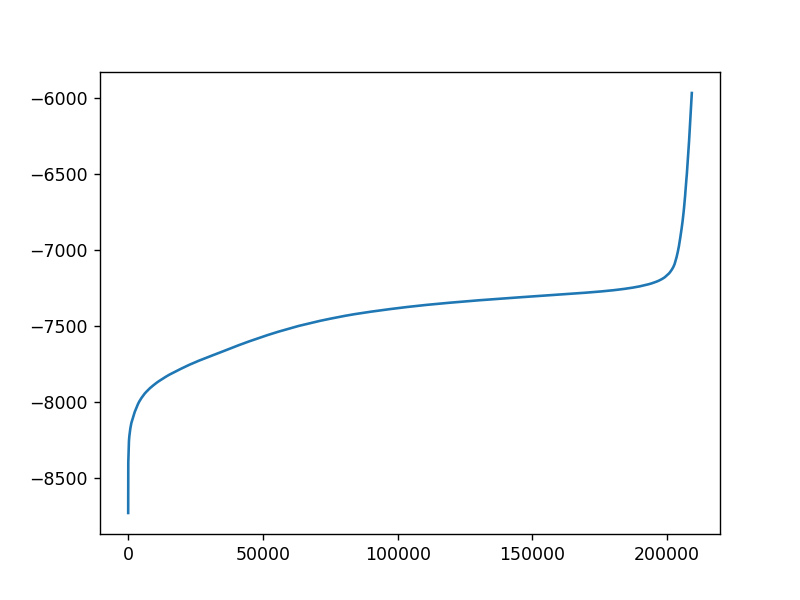

In [48]:
plt.plot(num_nodes_below_threshold,threshold_pes)

NameError: name 'plt' is not defined